### Importation de bibliotheque

In [1]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import os
import joblib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,RMSprop 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

2024-04-23 23:37:03.445318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 23:37:17.914129: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/lib64:/home/hassouni/miniconda3/envs/tf/lib/
2024-04-23 23:37:17.914490: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; 

### Modeling

##### 1. Data preprocessing

In [3]:
df = pd.read_csv('features.csv')
df.shape

(48648, 2377)

In [4]:
# Fill NaN with 0
df = df.fillna(0)
print(df.isna().any())

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


In [5]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.343262,0.448730,0.500000,0.472168,0.376953,0.439453,0.539551,0.511230,0.388184,0.299316,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,surprise
1,0.237305,0.352051,0.480957,0.489258,0.499023,0.502930,0.502930,0.510254,0.506836,0.517578,...,-1.159168,-2.651012,-0.238043,1.710331,3.874244,3.927960,3.870702,2.359449,-1.600155,surprise
2,0.040527,0.081543,0.097168,0.097656,0.083984,0.067871,0.111328,0.174805,0.253418,0.312500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,surprise
3,0.150879,0.209961,0.234863,0.159180,0.112305,0.090820,0.163574,0.262207,0.368652,0.443848,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,surprise
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024414,0.080078,...,-1.461556,-4.752707,-3.807003,1.825411,1.365022,-2.007692,-1.409204,0.004334,-0.162669,neutral
5,0.248535,0.370605,0.499023,0.488770,0.486816,0.491211,0.480957,0.491211,0.487793,0.484375,...,1.029761,-1.071905,-2.751098,-2.249093,1.726952,-0.287437,-0.339736,-2.203024,-6.504035,neutral
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.018066,0.171875,0.291016,0.400391,0.500488,...,-0.122060,-0.169449,-0.269932,-0.237582,0.063637,0.434990,0.586418,0.597823,0.815498,neutral
7,0.252930,0.372559,0.497559,0.490234,0.490723,0.509766,0.519531,0.528809,0.523926,0.515137,...,1.635882,1.303709,-2.683839,0.486808,-0.231289,-3.244521,-0.897827,0.241259,-0.361168,neutral
8,0.256348,0.381836,0.517578,0.519531,0.518555,0.516602,0.516602,0.506348,0.504883,0.506836,...,-2.800925,-20.028423,-22.917688,-6.553454,1.511625,-7.332297,-8.524702,4.480391,10.784654,angry
9,0.256348,0.384277,0.510742,0.501953,0.512695,0.505371,0.501953,0.502441,0.498047,0.498047,...,-0.904455,-6.651814,-8.334980,-3.001392,-1.157969,-1.033050,1.678392,7.205414,9.771869,angry


In [5]:
X = df.drop(labels="labels", axis=1)
Y = df["labels"]

In [6]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
Y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((38918, 2376), (9730, 2376), (38918, 7), (9730, 7))

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((35026, 2376), (9730, 2376), (3892, 2376), (35026, 7), (9730, 7), (3892, 7))

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((35026, 2376), (9730, 2376), (3892, 2376), (35026, 7), (9730, 7), (3892, 7))

In [10]:
joblib.dump(scaler,'scaler.pkl')

['scaler.pkl']

In [11]:
# We have to use 1-dimensional CNN which need specifical shape:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(35026, 2376, 1)

##### 2. Model with feature zrc, mfcc et rmse

In [12]:
earlystopping = EarlyStopping(
                        monitor ="val_acc",
                        mode = 'auto', patience = 5,
                        restore_best_weights = True
                    )

In [13]:
learning_rate_reduction = ReduceLROnPlateau(
                                monitor='val_acc',
                                patience=3,
                                verbose=1,
                                factor=0.5,
                                min_lr=0.00001
                            )

In [14]:
model = models.Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1, padding="same", activation="relu", input_shape=(X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(512, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))
model.add(layers.Dropout(0.1))


model.add(layers.Conv1D(256, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(layers.Dropout(0.1))


model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(7, activation="softmax"))
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])
model.summary()

2024-04-23 23:42:18.564371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-23 23:42:19.233357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-23 23:42:19.234194: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-23 23:42:19.264562: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 512)         3072      
                                                                 
 batch_normalization (BatchN  (None, 2376, 512)        2048      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1188, 512)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_1 (Batc  (None, 1188, 512)        2048      
 hNormalization)                                                 
                                                        

In [16]:
with tf.device('/GPU:0'):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),callbacks=[learning_rate_reduction, earlystopping],
                    epochs=50, batch_size=64)

Epoch 1/50


2024-02-09 20:09:01.239885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-02-09 20:09:04.674540: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x25380030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-09 20:09:04.674615: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 with Max-Q Design, Compute Capability 7.5
2024-02-09 20:09:04.689664: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-09 20:09:05.034304: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


548/548 [==============================] - 196s 325ms/step - loss: 1.4370 - acc: 0.4601 - val_loss: 1.8690 - val_acc: 0.3970 - lr: 0.0010
Epoch 2/50
548/548 [==============================] - 177s 323ms/step - loss: 1.0870 - acc: 0.5763 - val_loss: 1.3543 - val_acc: 0.5033 - lr: 0.0010
Epoch 3/50
548/548 [==============================] - 178s 325ms/step - loss: 0.9527 - acc: 0.6348 - val_loss: 1.2580 - val_acc: 0.5242 - lr: 0.0010
Epoch 4/50
548/548 [==============================] - 179s 326ms/step - loss: 0.8171 - acc: 0.6894 - val_loss: 0.9930 - val_acc: 0.6238 - lr: 0.0010
Epoch 5/50
548/548 [==============================] - 179s 326ms/step - loss: 0.6829 - acc: 0.7455 - val_loss: 0.8992 - val_acc: 0.6734 - lr: 0.0010
Epoch 6/50
548/548 [==============================] - 179s 326ms/step - loss: 0.5309 - acc: 0.8067 - val_loss: 0.6563 - val_acc: 0.7603 - lr: 0.0010
Epoch 7/50
548/548 [==============================] - 179s 327ms/step - loss: 0.3909 - acc: 0.8594 - val_loss: 0.7780

305/305 [==============================] - 16s 51ms/step - loss: 0.2439 - acc: 0.9565
Accuracy of our model on test data :  95.65262198448181 %


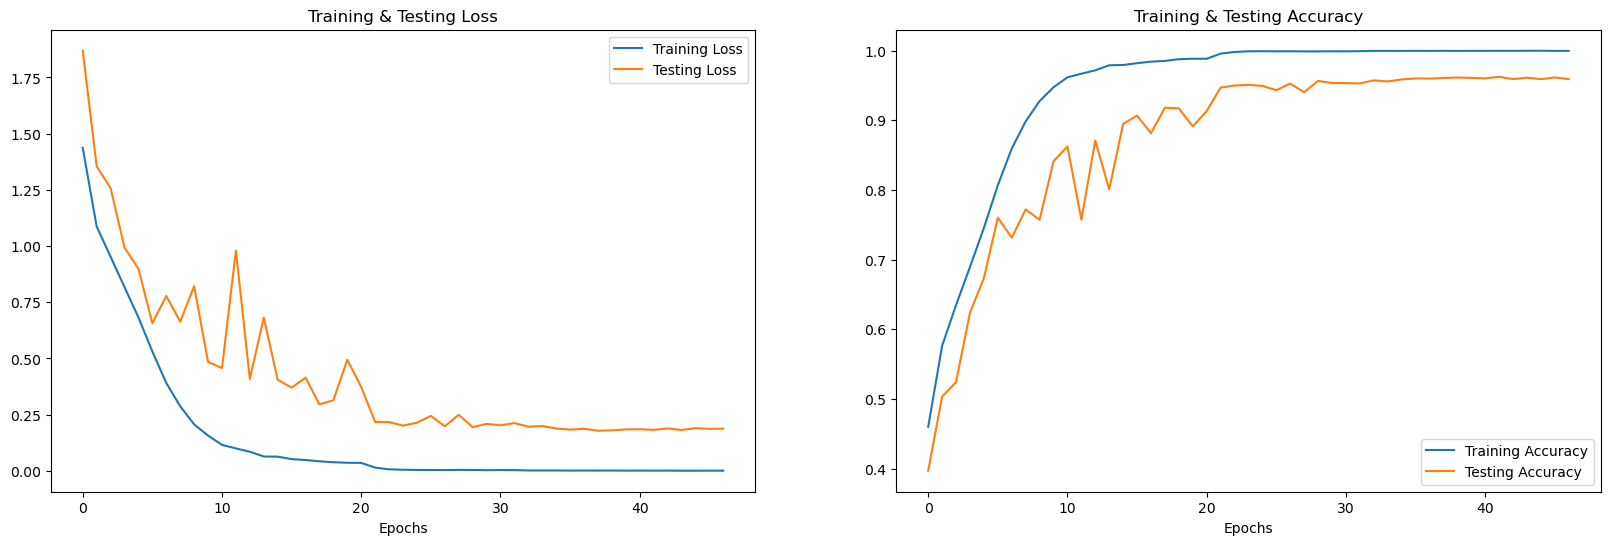

In [17]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [18]:
# predicting on test data.
pred_test = model.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)

y_test1 = encoder.inverse_transform(y_test)

305/305 [==============================] - 15s 46ms/step


In [19]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test1.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,surprise,surprise
1,neutral,neutral
2,angry,angry
3,fear,fear
4,neutral,neutral
5,neutral,neutral
6,neutral,neutral
7,sad,sad
8,sad,sad
9,surprise,surprise


In [20]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1416    7    9   16    1    3    5]
 [  23 1478   13    5   10   27    3]
 [  18   11 1508   16   11   24    4]
 [  23   13   21 1459   17    7    2]
 [   4   13    9   12 1461   16    0]
 [   1   14   23    3   15 1473    2]
 [   6    1    2    4    0    9  512]]


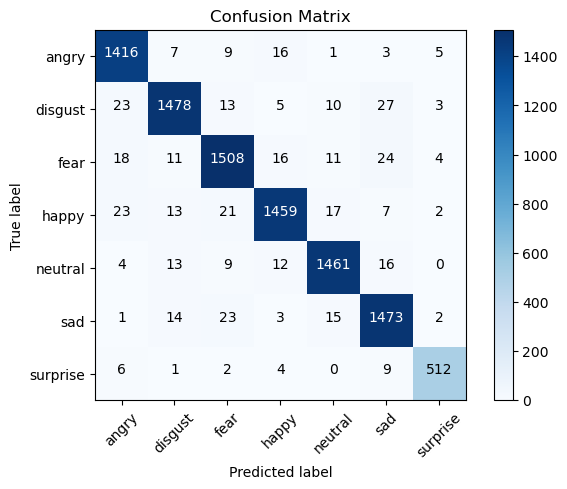

In [21]:
cm = confusion_matrix(y_test1, y_pred)
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [24]:
from sklearn.metrics import classification_report
print(f'Model Confusion Matrix\n',classification_report(y_test1,y_pred,target_names=cm_plot_labels))

Model Confusion Matrix
               precision    recall  f1-score   support

       angry       0.95      0.97      0.96      1457
     disgust       0.96      0.95      0.95      1559
        fear       0.95      0.95      0.95      1592
       happy       0.96      0.95      0.95      1542
     neutral       0.96      0.96      0.96      1515
         sad       0.94      0.96      0.95      1531
    surprise       0.97      0.96      0.96       534

    accuracy                           0.96      9730
   macro avg       0.96      0.96      0.96      9730
weighted avg       0.96      0.96      0.96      9730



In [25]:
# save model
model.save("./model_all.h5")

In [26]:
# save encoder
joblib.dump(encoder,'encoder_all.pkl')

['encoder_all.pkl']